In [1]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt


data_dir = r'C:\Users\Habeeb\Downloads\Finale\dataset'

# ImageDataGenerator for preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 20% of the data for validation
)

# Training data generator
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),  # Resizing images to 224x224
    batch_size=32,
    class_mode='binary',
    subset='training',  #training subset
    shuffle=True
)

# Validation data generator
validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # validation subset
)


Found 1325 images belonging to 2 classes.
Found 331 images belonging to 2 classes.


In [2]:
# Loading the VGG16 model
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Extracting features from training and validation images
def extract_features(generator, model):
    features = []
    labels = []
    for inputs_batch, labels_batch in generator:
        features_batch = model.predict(inputs_batch)
        features.append(features_batch)
        labels.append(labels_batch)
        if len(features) * generator.batch_size >= generator.samples:
            break
    return np.concatenate(features), np.concatenate(labels)

train_features, train_labels = extract_features(train_generator, vgg16_base)
validation_features, validation_labels = extract_features(validation_generator, vgg16_base)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 

In [2]:
# Flatten the features to fit Random Forest input
train_features = train_features.reshape(train_features.shape[0], -1)
validation_features = validation_features.reshape(validation_features.shape[0], -1)

# Standardize the features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
validation_features = scaler.transform(validation_features)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=500)  # Adjust the number of components based on your dataset
train_features = pca.fit_transform(train_features)
validation_features = pca.transform(validation_features)

# Using SMOTE (for oversampling the minority class)
smote = SMOTE(random_state=42)
train_features_resampled, train_labels_resampled = smote.fit_resample(train_features, train_labels)



NameError: name 'train_features' is not defined

In [4]:
# Train the Random Forest model with resampled data
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
rf_model.fit(train_features_resampled, train_labels_resampled)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [10, 20, 30, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [5]:
#Evaluate the model on the validation set
val_predictions = rf_model.predict(validation_features)

# Generate classification report and confusion matrix
print(classification_report(validation_labels, val_predictions, target_names=train_generator.class_indices.keys()))
conf_matrix = confusion_matrix(validation_labels, val_predictions)
print(conf_matrix)


              precision    recall  f1-score   support

non-trachoma       0.70      0.63      0.66       203
    positive       0.49      0.57      0.53       128

    accuracy                           0.60       331
   macro avg       0.59      0.60      0.59       331
weighted avg       0.62      0.60      0.61       331

[[127  76]
 [ 55  73]]


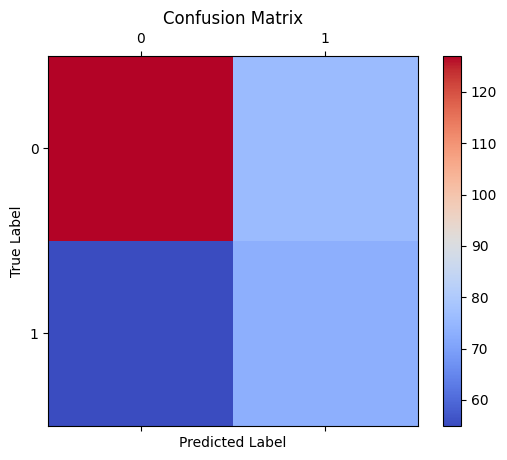

In [6]:
fig, ax = plt.subplots()
cax = ax.matshow(conf_matrix, cmap='coolwarm')
fig.colorbar(cax)
ax.set_title('Confusion Matrix')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')

# Save the figure
fig.savefig('random_forest.png')

# Display the plot
plt.show()

In [1]:
from sklearn.metrics import roc_auc_score

# Assuming you have the true labels for the validation set
val_labels = validation_generator.classes


# Random Forest: Get the predicted probabilities
rf_probabilities = rf_model.predict_proba(validation_features)[:, 1]
roc_auc_rf = roc_auc_score(val_labels, rf_probabilities)

print(f'Random Forest ROC AUC: {roc_auc_rf}')

NameError: name 'validation_generator' is not defined